In [1234]:
# Importing necessary Libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [1236]:
# Variable that sets the file path for the dataset.

file_path = '/Users/tony/Documents/Shoes_Socks_DataSet'

# Variables that are used in the training stage of the model.

learning_rate = 0.0002
BATCH_SIZE = 16
num_of_epochs = 25

In [1238]:
# Pre-Processing Stage


# Defining the resizing and conversion of images from the dataset.

image_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.4),
    # transforms.Grayscale(),
    transforms.ColorJitter(brightness=0.4,hue=0.3),
    # transforms.RandomAffine(14),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
)

# Loading the dataset

dataset = datasets.ImageFolder(file_path,transform = image_transforms)

# Accessing the images from the training set

train_set = datasets.ImageFolder(file_path+ '/Train', transform=image_transforms)

# Accessing the images from the validation set

validation_set = datasets.ImageFolder(file_path+ '/Validation', transform=image_transforms)

# Accessing the images from the test set

test_set = datasets.ImageFolder(file_path+'/Test', transform=image_transforms)


# Creating the DataLoaders


# Loading the images from the training set 

train_loader = DataLoader(train_set,BATCH_SIZE,shuffle=True)

# Loading the images from the validation set 

val_loader = DataLoader(validation_set,BATCH_SIZE,shuffle=False)

# Loading the images from the test set 

test_loader = DataLoader(test_set,BATCH_SIZE,shuffle=False)

# Putting all of these loaders into one variable

loaders = {'train': train_loader,
           'validate': val_loader,
           'test': test_loader}

# A list of all the class names from the Dataset


class_name = train_set.classes

# Number of class names from Dataset
num_of_classes = len(class_name)

In [1239]:
# Defining a ResNet18 model using Transfer Learning. 

import torchvision
from torchvision import models

model = torchvision.models.resnet18(weights=True)
model.fc = nn.Linear(model.fc.in_features,1)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1240]:
# Defining the Validation and Training Stages

device = ''
if (torch.cuda.is_available()):
  device = 'cuda'
else:
  device = 'cpu'

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


loss_fn = nn.BCEWithLogitsLoss()

def validate(model,val_loader,loss_fn):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target = target.unsqueeze(1).float()
            output = model(data)
            val_loss += loss_fn(output, target).item()

            pred = (output > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.numel()

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total

    return val_loss, accuracy

def train(model,epochs,patience=5):

    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0


    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(loaders['train']):
            data, target = data.to(device), target.to(device)
            target = target.unsqueeze(1).float()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pred = (output > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.numel()

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} '
                      f'({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

        # Validation phase
        val_loss, val_acc = validate(model, loaders['validate'], loss_fn)
        train_loss /= len(loaders['train'])
        train_acc = 100. * correct / total

        train_accuracy_list.append(train_acc)
        val_accuracy_list.append(val_acc)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f'\nEpoch {epoch}:')
        print(f'Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Validation loss improved. Model saved.')
        else:
            epochs_no_improve += 1
            print(f'No improvement in validation loss for {epochs_no_improve} epochs')
            if epochs_no_improve >= patience:
                print(f'Early stopping after {epoch} epochs')
                break


    # plt.subplot(1,2,2)
    plt.plot(train_accuracy_list,label= 'Train Accuracy')
    plt.plot(val_accuracy_list,label= "Validation Accuracy")
    plt.title("Train & Validation Accuracy")
    plt.xlabel("epocs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plt.subplot(1,2,1)
    plt.plot(train_loss_list,label="Training Loss")
    plt.plot(val_loss_list,label= "Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()


    plt.show()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model


In [1241]:
# Defining the testing stage

def test_model(model, test_loader, print_samples=5):
    model.eval()

    # Adjusted for binary classification with a single output
    true_positives = torch.zeros(1).to(device)
    false_positives = torch.zeros(1).to(device)
    false_negatives = torch.zeros(1).to(device)
    # Added for negative class metrics
    true_negatives = torch.zeros(1).to(device)

    exact_matches = 0
    total_samples = 0

    # For sample printing
    samples_shown = 0
    # Updated class names for binary classification
    class_names = test_loader.dataset.classes

    print("\nTesting model...")
    print("-" * 50)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Unsqueeze labels to match model output shape
            labels = labels.unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()

            # Update statistics for binary classification
            true_positives += (predicted * labels).sum()
            false_positives += (predicted * (1 - labels)).sum()
            false_negatives += ((1 - predicted) * labels).sum()
            # Update for true negatives
            true_negatives += ((1 - predicted) * (1 - labels)).sum()


            # Exact match ratio (for binary classification, this is simply accuracy)
            exact_matches += (predicted == labels).sum().item()
            total_samples += labels.numel() # Use numel() for single-element targets

            # Print sample predictions
            if samples_shown < print_samples:
                for i in range(labels.size(0)):
                    if samples_shown >= print_samples:
                        break

                    # Corrected logic for printing binary predictions
                    true_label = class_names[labels[i].long().item()] # Use long() to get the index
                    pred_label = class_names[int(predicted[i].item())]

                    correct_str = "✓" if (predicted[i] == labels[i]) else "✗"
                    print(f"  {correct_str} Pred: {pred_label:<15} (True: {true_label})")
                    samples_shown += 1

    # Calculate metrics for binary classification
    # For Positive Class (Socks - assuming this is class 1)
    precision_pos = true_positives / (true_positives + false_positives + 1e-10)
    recall_pos = true_positives / (true_positives + false_negatives + 1e-10)
    f1_pos = 2 * (precision_pos * recall_pos) / (precision_pos + recall_pos + 1e-10)

    # For Negative Class (Shoes - assuming this is class 0)
    precision_neg = true_negatives / (true_negatives + false_negatives + 1e-10) # TP_neg / (TP_neg + FP_neg) where FP_neg = FN_pos
    recall_neg = true_negatives / (true_negatives + false_positives + 1e-10) # TP_neg / (TP_neg + FN_neg) where FN_neg = FP_pos
    f1_neg = 2 * (precision_neg * recall_neg) / (precision_neg + recall_neg + 1e-10)


    exact_match_accuracy = 100. * exact_matches / total_samples

    print("\nPerformance Metrics:")
    print("-" * 50)
    # Metrics for the positive class (index 1, typically 'Socks')
    print(f"{class_names[1]:<15} (Positive Class)")
    print(f"  Precision: {precision_pos.item()*100:.2f}%")
    print(f"  Recall:    {recall_pos.item()*100:.2f}%")
    print(f"  F1 Score:  {f1_pos.item()*100:.2f}%")
    print("-" * 50)

    # Metrics for the negative class (index 0, typically 'Shoes')
    print(f"{class_names[0]:<15} (Negative Class)")
    print(f"  Precision: {precision_neg.item()*100:.2f}%")
    print(f"  Recall:    {recall_neg.item()*100:.2f}%")
    print(f"  F1 Score:  {f1_neg.item()*100:.2f}%")
    print("-" * 50)

    # Exact match accuracy is the overall accuracy for binary classification
    print(f"\nOverall Accuracy: {exact_match_accuracy:.2f}%")
    print("-" * 50)


    return {
        'precision_pos': precision_pos.cpu().numpy(),
        'recall_pos': recall_pos.cpu().numpy(),
        'f1_pos': f1_pos.cpu().numpy(),
        'precision_neg': precision_neg.cpu().numpy(),
        'recall_neg': recall_neg.cpu().numpy(),
        'f1_neg': f1_neg.cpu().numpy(),
        'exact_match_accuracy': exact_match_accuracy
    }

In [1245]:
# Defining the Confusion Matrix for Evaluation

def create_confusion_matrix_manual(model, test_loader, num_classes, device):
    model.eval()
    # Confusion matrix for binary classification
    confusion_matrix = torch.zeros(2, 2) # 2x2 matrix for binary classification
    class_names = train_set.classes # Get class names from train_set

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            # Unsqueeze labels to match predicted shape
            labels = labels.unsqueeze(1)

            outputs = model(data)
            # For binary classification with BCEWithLogitsLoss and single output,
            # predictions are obtained by thresholding the output logits.
            preds = (outputs > 0.5).long() # Convert boolean to long (0 or 1)

            # Reshape labels and preds to 1D for easy iteration
            labels = labels.view(-1)
            preds = preds.view(-1)

            for t, p in zip(labels, preds):
                confusion_matrix[t.long(), p.long()] += 1

    # Normalize the confusion matrix
    cm_normalized = confusion_matrix / (confusion_matrix.sum(1, keepdim=True) + 1e-10) # Add small epsilon for stability

    # Plotting
    plt.figure(figsize=(8, 6)) # Adjusted size for binary matrix
    plt.imshow(cm_normalized.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    # Set tick labels to class names
    tick_marks = torch.arange(2)
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{confusion_matrix[i, j]:.0f}\n({cm_normalized[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")

    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return confusion_matrix



In [1243]:
# Creating the prediction method for any image

from PIL import Image
import torch
import torch.nn.functional as F
import torchvision
from sklearn.metrics import f1_score
from torchvision import transforms # Ensure transforms is imported


def predict_custom_image(model, image_path, class_names):
    """
    Predict image class with automatic device detection (CUDA if available, otherwise CPU)

    Args:
        model: Trained PyTorch model
        image_path: Path to image file
        class_names: List of class names (order must match training - ['Shoes', 'Socks'])

    Returns:
        tuple: (predicted_class, confidence, all_probs)
    """
    # Set device automatically
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Model setup
    model = model.to(device)
    model.eval()

    # Preprocessing - MUST MATCH TRAINING PREPROCESSING
    # Use the same transformations as used for training data loaders
    transform = transforms.Compose([
        # transforms.Grayscale(), # Ensure 1 channel
        transforms.Resize((128, 128)), # Resize to model input size
        transforms.ToTensor(), # Convert PIL Image to PyTorch tensor (1 channel)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        # Load and preprocess image
        img = Image.open(image_path)
        img = img.convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Prediction
        with torch.no_grad():
            output = model(img_tensor)
            # Apply sigmoid to the single logit output
            # This gives the probability of the positive class (index 1, 'Socks')
            prob_positive_class = torch.sigmoid(output[0])

        # For binary classification, the output is a single value (logit).
        # Applying sigmoid gives the probability of the positive class.
        # We can determine the predicted class by thresholding this probability (e.g., 0.5).
        predicted_class_idx = (prob_positive_class > 0.5).long().item()
        predicted_class = class_names[predicted_class_idx]
        confidence = prob_positive_class.item() if predicted_class_idx == 1 else (1 - prob_positive_class.item())

        # Prepare results dictionary
        # Assign probabilities based on the class order in class_names
        # Assuming class_names is ['Shoes', 'Socks'] where 'Socks' is the positive class (index 1)
        all_probs = {
            class_names[0]: f"{(1 - prob_positive_class.item())*100:.1f}%", # Probability of negative class ('Shoes')
            class_names[1]: f"{prob_positive_class.item()*100:.1f}%" # Probability of positive class ('Socks')
        }


        plt.imshow(img)
        plt.title(f"Predicted {predicted_class}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        return predicted_class, confidence, all_probs

    except Exception as e:
        # Re-raise the exception with a more informative message
        raise RuntimeError(f"Prediction failed: {str(e)}")

# Training Stage

train(model,num_of_epochs)

Epoch: 1 [0/700 (0%)]	Loss: 0.798798
Epoch: 1 [160/700 (23%)]	Loss: 0.239516
Epoch: 1 [320/700 (45%)]	Loss: 0.157083
Epoch: 1 [480/700 (68%)]	Loss: 0.118403
Epoch: 1 [640/700 (91%)]	Loss: 0.053262

Epoch 1:
Train Loss: 0.2635 | Accuracy: 87.14%
Val Loss: 0.5115 | Accuracy: 85.33%
Validation loss improved. Model saved.
Epoch: 2 [0/700 (0%)]	Loss: 0.067971
Epoch: 2 [160/700 (23%)]	Loss: 0.090880
Epoch: 2 [320/700 (45%)]	Loss: 0.232445
Epoch: 2 [480/700 (68%)]	Loss: 0.113626
Epoch: 2 [640/700 (91%)]	Loss: 0.150964

Epoch 2:
Train Loss: 0.2150 | Accuracy: 91.86%
Val Loss: 0.4746 | Accuracy: 78.67%
Validation loss improved. Model saved.
Epoch: 3 [0/700 (0%)]	Loss: 0.020387
Epoch: 3 [160/700 (23%)]	Loss: 0.291714
Epoch: 3 [320/700 (45%)]	Loss: 0.383229
Epoch: 3 [480/700 (68%)]	Loss: 0.094669
Epoch: 3 [640/700 (91%)]	Loss: 0.045274

Epoch 3:
Train Loss: 0.1513 | Accuracy: 93.43%
Val Loss: 0.3763 | Accuracy: 86.00%
Validation loss improved. Model saved.
Epoch: 4 [0/700 (0%)]	Loss: 0.211629
Epo

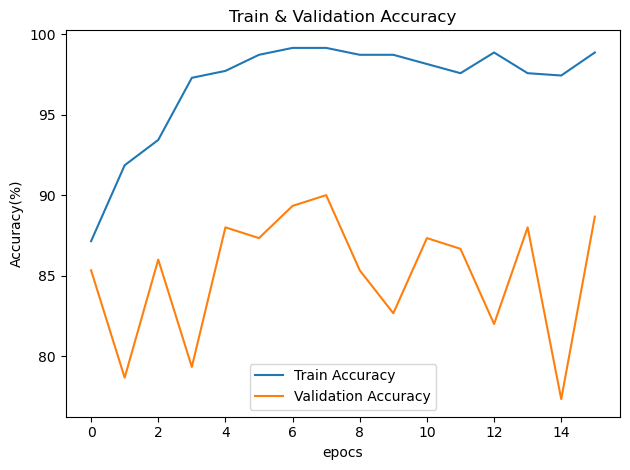

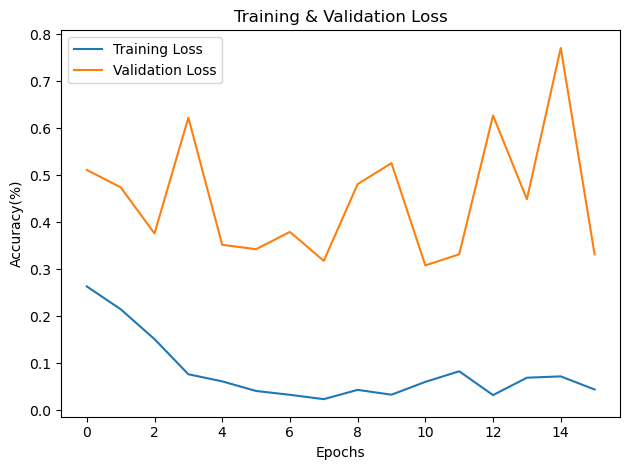

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [1246]:
# Training Stage

train(model,num_of_epochs)

In [1247]:
# Testing Stage

test_model(model,test_loader)


Testing model...
--------------------------------------------------
  ✓ Pred: Shoes           (True: Shoes)
  ✓ Pred: Shoes           (True: Shoes)
  ✓ Pred: Shoes           (True: Shoes)
  ✓ Pred: Shoes           (True: Shoes)
  ✓ Pred: Shoes           (True: Shoes)

Performance Metrics:
--------------------------------------------------
Socks           (Positive Class)
  Precision: 93.06%
  Recall:    89.33%
  F1 Score:  91.16%
--------------------------------------------------
Shoes           (Negative Class)
  Precision: 89.74%
  Recall:    93.33%
  F1 Score:  91.50%
--------------------------------------------------

Overall Accuracy: 91.33%
--------------------------------------------------


{'precision_pos': array([0.9305556], dtype=float32),
 'recall_pos': array([0.8933333], dtype=float32),
 'f1_pos': array([0.91156465], dtype=float32),
 'precision_neg': array([0.8974359], dtype=float32),
 'recall_neg': array([0.93333334], dtype=float32),
 'f1_neg': array([0.9150327], dtype=float32),
 'exact_match_accuracy': 91.33333333333333}

In [1248]:
# predictions = Shoe_Socks_Classifier(model)

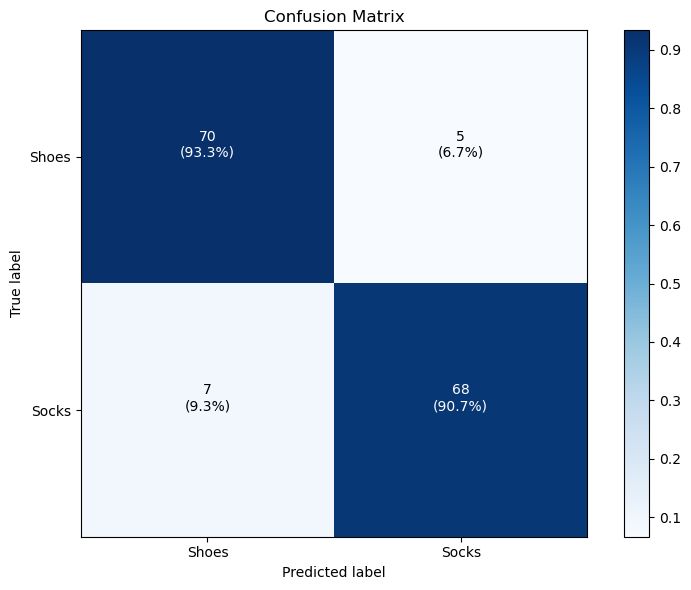

tensor([[70.,  5.],
        [ 7., 68.]])

In [1249]:
# Creating the Confusion Matrix


create_confusion_matrix_manual(model,test_loader,num_of_classes,device)

Using device: cpu


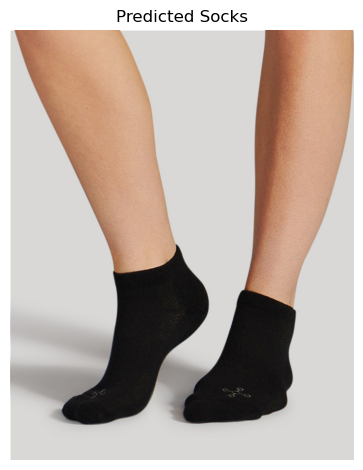


Prediction Results:
Most likely: Socks (99.94% confidence)

All class probabilities:
Shoes: 0.1%
Socks: 99.9%


In [1251]:
# Prediction Stage 1: Socks 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/2743WR_black_1__63485.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


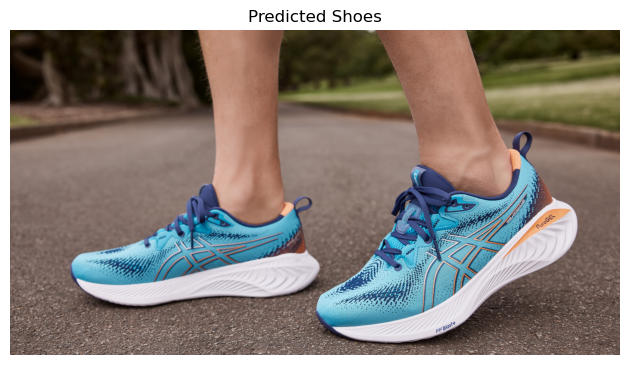


Prediction Results:
Most likely: Shoes (87.54% confidence)

All class probabilities:
Shoes: 87.5%
Socks: 12.5%


In [1252]:
# Prediction Stage 2: Shoes 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/SS23_GEL-CUMULUS-25_Highlight_CHIASI0016_SH09_03_FINAL.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


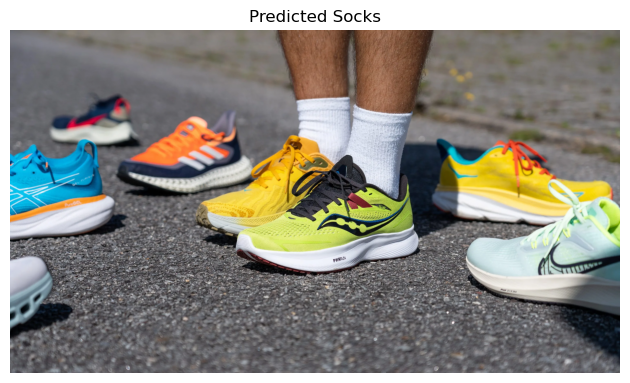


Prediction Results:
Most likely: Socks (68.81% confidence)

All class probabilities:
Shoes: 31.2%
Socks: 68.8%


In [1253]:
# Prediction Stage 3: Shoes 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/269-best-daily-running-shoes-15820218-main.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


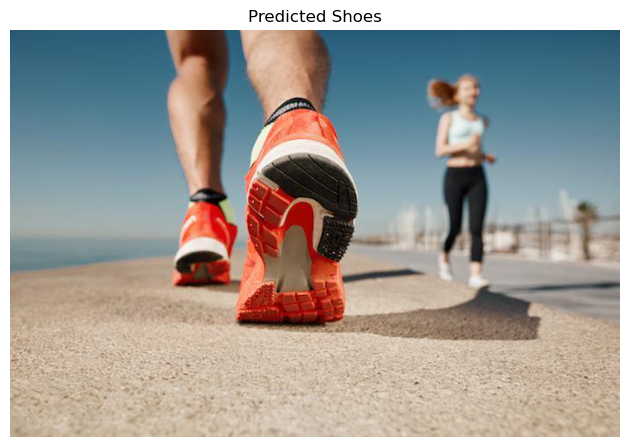


Prediction Results:
Most likely: Shoes (68.05% confidence)

All class probabilities:
Shoes: 68.1%
Socks: 31.9%


In [1254]:
# Prediction Stage 4: Shoes 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/2011997.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


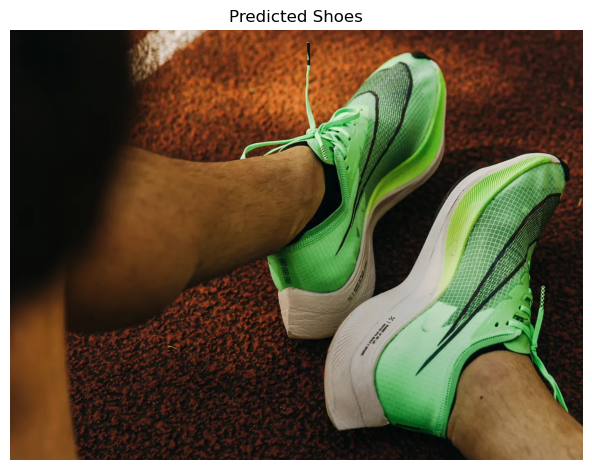


Prediction Results:
Most likely: Shoes (97.75% confidence)

All class probabilities:
Shoes: 97.7%
Socks: 2.3%


In [1255]:
# Prediction Stage 5: Shoes 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/Best-Nike-Running-Shoes-Masthead.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

In [1279]:
torch.save(model.state_dict(), 'new_model.pth')


Using device: cpu


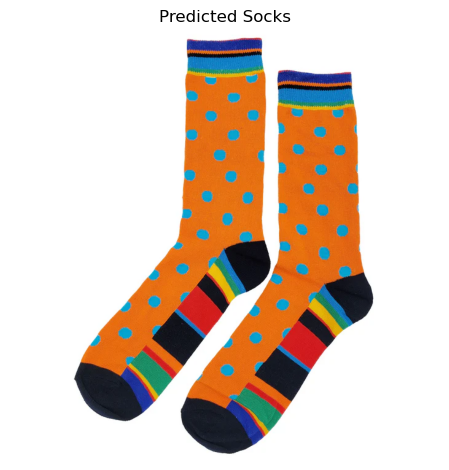


Prediction Results:
Most likely: Socks (100.00% confidence)

All class probabilities:
Shoes: 0.0%
Socks: 100.0%


In [1256]:
# Prediction Stage 6: Socks 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/Wild_Color_1_42022ab2-5d0c-4b56-bccb-418385c92b12_700x700.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


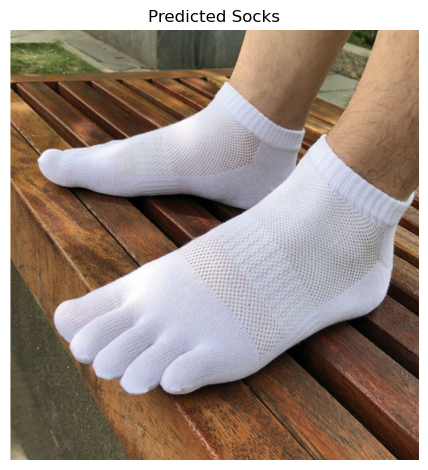


Prediction Results:
Most likely: Socks (100.00% confidence)

All class probabilities:
Shoes: 0.0%
Socks: 100.0%


In [1257]:
# Prediction Stage 7: Socks 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/s-l1200jpg.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


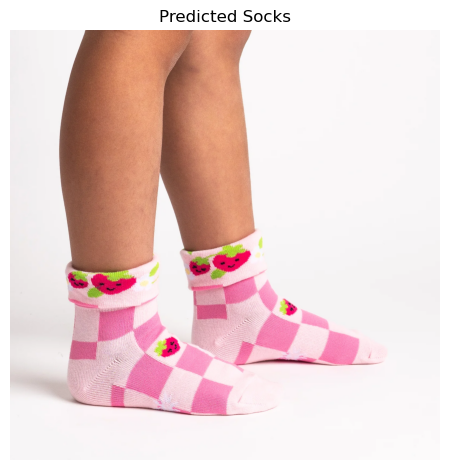


Prediction Results:
Most likely: Socks (99.99% confidence)

All class probabilities:
Shoes: 0.0%
Socks: 100.0%


In [1258]:
# Prediction Stage 8: Socks 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/JQ0015-YQ0015-BerryCute-KidsTurnCuff-Model_CuffDown_Front.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


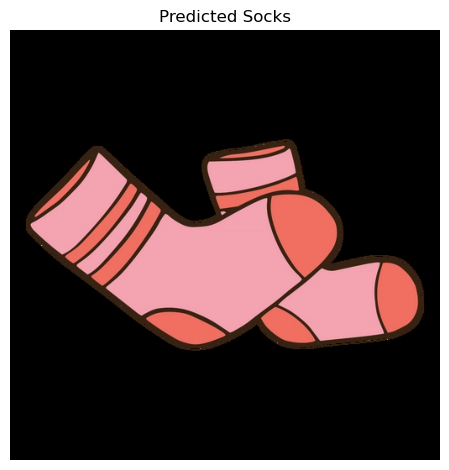


Prediction Results:
Most likely: Socks (78.26% confidence)

All class probabilities:
Shoes: 21.7%
Socks: 78.3%


In [1259]:
# Prediction Stage 9: Socks 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/d3ed3c976ee4bad3d7a4f9bdac2e5bee-pair-of-socks.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


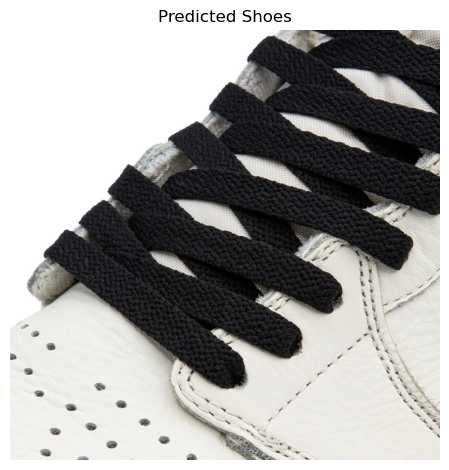


Prediction Results:
Most likely: Shoes (91.93% confidence)

All class probabilities:
Shoes: 91.9%
Socks: 8.1%


In [1270]:
# Prediction Stage 10: Shoes 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/black-jordan-1-replacement-shoelaces-675714.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


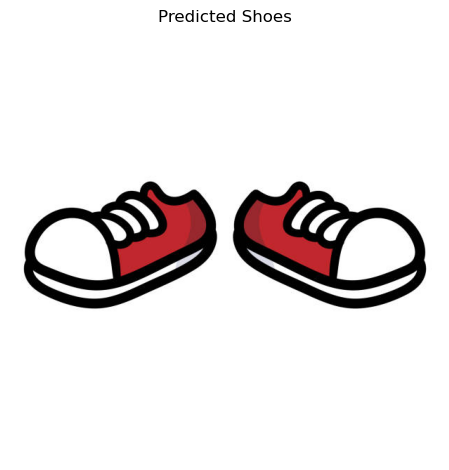


Prediction Results:
Most likely: Shoes (100.00% confidence)

All class probabilities:
Shoes: 100.0%
Socks: 0.0%


In [1274]:
# Prediction Stage 11: Shoes 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/istockphoto-930045832-612x612.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


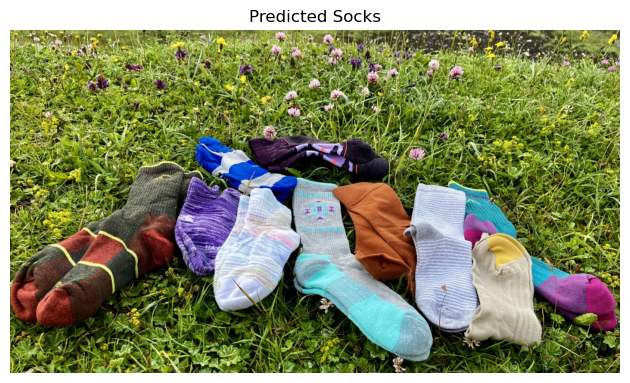


Prediction Results:
Most likely: Socks (90.04% confidence)

All class probabilities:
Shoes: 10.0%
Socks: 90.0%


In [1277]:
# Prediction Stage 12: Socks 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/425330_3704_XL.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


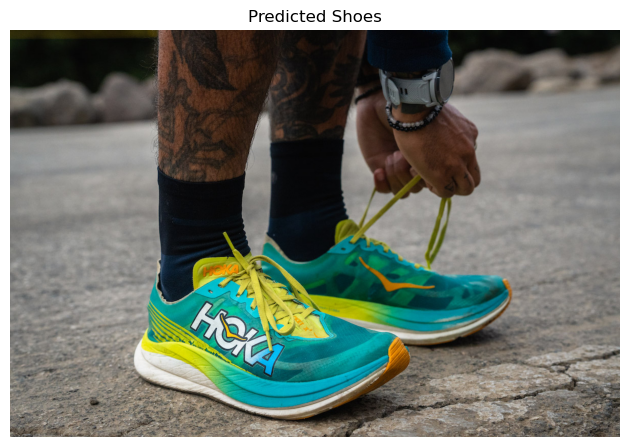


Prediction Results:
Most likely: Shoes (88.76% confidence)

All class probabilities:
Shoes: 88.8%
Socks: 11.2%


In [1276]:
# Prediction Stage 13: Shoes 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Best-Road-Running-Shoe-tying-laces-of-Hoka-Rocket-X-2.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


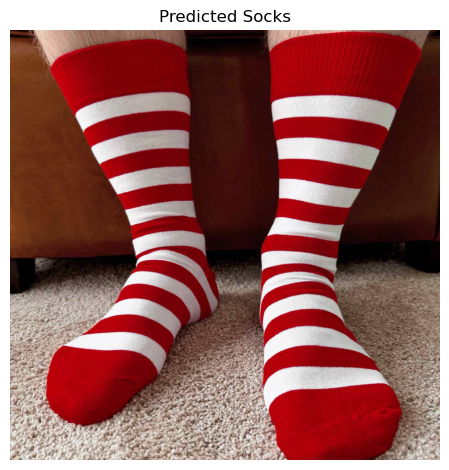


Prediction Results:
Most likely: Socks (100.00% confidence)

All class probabilities:
Shoes: 0.0%
Socks: 100.0%


In [1261]:
# Prediction Stage 14: Socks 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ShoeSockPredict/red-white-striped-socks-worn_1001x1001@2x.jpg',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


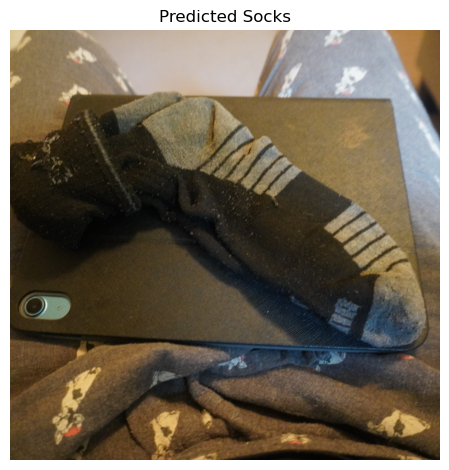


Prediction Results:
Most likely: Socks (77.76% confidence)

All class probabilities:
Shoes: 22.2%
Socks: 77.8%


In [1267]:
# Prediction Stage 15: Socks 

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Documents/Shoes_Socks_DataSet/Test/Socks/DSC02166.JPG',
            class_names=class_name
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

### 